In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import optimize
from scipy.stats import poisson
import math

In [5]:
#import data from excel
#data = pd.read_excel('/Users/ibhallaladd/Desktop/sup_junc_data.xlsx', dtype={'Name': str, 'Value': float}, keep_default_na = False)
data = pd.read_excel(r'C:\Users\clair\OneDrive\Schewl\Junior_Year\AdvancedLab\adv_lab-master\sup_junc_data.xlsx', dtype={'Name': str, 'Value': float}, keep_default_na = False)


In [22]:
data

,NIN_1_1_inc_I,NIN_1_1_inc_V,NIN_1_1_inc_V_err,NIN_1_1_dec_I,NIN_1_1_dec_V,NIN_1_1_dec_V_err,SIN_1_1_inc_I,SIN_1_1_inc_V,SIN_1_1_inc_V_err,SIN_1_1_dec_I,SIN_1_1_dec_V,SIN_1_1_dec_V_err,SIS_1_1_inc_I,SIS_1_1_inc_V,SIS_1_1_inc_V_err,SIS_1_1_dec_I,SIS_1_1_dec_V,SIS_1_1_dec_V_err
0,-0.0005,-0.0073252,1.5418e-05,-0.0005,-0.0073274,2.7669e-05,-0.0005,-0.0090332,0,-0.0005,-0.0090315,2.0365e-05,-0.00002,-0.001388,0.000003,-0.00002,-0.001396,0.000003
1,-0.00049,-0.0073076,6.1492e-05,-0.00049,-0.0073242,0,-0.00049,-0.008792,2.6597e-05,-0.00049,-0.0087898,1.3359e-05,-0.00002,-0.001387,0.000003,-0.00002,-0.001395,0.000003
2,-0.00048,-0.0070801,0,-0.00048,-0.0070854,3.5829e-05,-0.00048,-0.0087288,0.00010534,-0.00048,-0.0086831,0.00012106,-0.00002,-0.001387,0.000002,-0.00002,-0.001394,0.000004
3,-0.00047,-0.0070271,0.00010069,-0.00047,-0.0070586,6.9198e-05,-0.00047,-0.0085449,0,-0.00047,-0.0085449,0,-0.00002,-0.001386,0.000002,-0.00002,-0.001393,0.000005
4,-0.00046,-0.0068359,0,-0.00046,-0.0068379,2.176e-05,-0.00046,-0.0083064,3.6616e-05,-0.00046,-0.008304,2.7669e-05,-0.00002,-0.001386,0.000003,-0.00002,-0.001391,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,,,,,,,,,,,,,0.00002,0.000918,0.000002,0.00002,0.000918,0.000002
397,,,,,,,,,,,,,0.00002,0.000918,0.000002,0.00002,0.000918,0.000002
398,,,,,,,,,,,,,0.00002,0.000919,0.000003,0.00002,0.000919,0.000004
399,,,,,,,,,,,,,0.00002,0.000920,0.000004,0.00002,0.000920,0.000004


In [13]:
#guesses for the fit parameters
R     = 0
delta = 0
T     = 0

firstGuess = [R, delta, T]

NIN_Vinc = data['NIN_1_1_inc_V'][0:100]
NIN_Iinc = data['NIN_1_1_inc_I'][0:100]
NIN_Vinc_err = data['NIN_1_1_inc_V_err'][0:100]

SIN_Vinc = data['SIN_1_1_inc_V'][0:100]
SIN_Iinc = data['SIN_1_1_inc_I'][0:100]
SIN_Vinc_err = data['SIN_1_1_inc_V_err'][0:100]

SIN_Vdec = data['SIN_1_1_dec_V'][0:100]
SIN_Idec = data['SIN_1_1_dec_I'][0:100]
SIN_Vdec_err = data['SIN_1_1_dec_V_err'][0:100]

In [21]:
def NINcurr(v, params=[]):
    r_0 = params[0]
    b   = params[1]
    
    i   = np.zeros(len(v))
    
    for j in range(len(v)):
        i[j] = v[j] * r_0 + b
   
    return i
    

In [7]:
def SINcurr(v, params=[]):
    # energy and temperature measured in voltage units
    #    1 meV = 1 mV
    #    1 K   = 0.0861 mV
    # Setting parameters
    
    r_0    = params[0]
    delta  = params[1]
    t      = params[2] 
    
    e_max  = 900 #cutoff for approximating integral
    e_step = 10 #step size for approximating integral
    #r_par  = 99999 #resistance parallel to junction
    
    e = np.arange(-e_max, e_max, e_step)
    nptse = len(e)
    
    #Import voltage data
    #Rather than taking this vector of uniformly spaced fake voltages,
    #you should import a vector containing your real voltage data.
    nptsv = len(v)
    ds_pb = np.zeros(nptse)
    di = np.zeros(nptse)
    itot = np.zeros(nptsv)
    
    # step over voltage
    # for k=1:nptsv
    for k in range(nptsv):
        vv = v[k]
        
        # do the integral over e
        for j in range(nptse):
            if np.absolute(e[j]) > delta:
                # tame divergence in bcs density of states used .99 instead of 1
                ds_pb[j] = np.absolute(e[j])/np.sqrt((e[j])**2-.99*delta**2)
                
            else:
                ds_pb[j] = 0
                
            di[j] = ds_pb[j]*(1/(np.exp(e[j]/t)+1)-1/(np.exp((e[j]+vv)/t)+1))
            
        # integrate with trapezoid rule include a parallel resistance r_par
        #itot[k] = np.trapz(di,e)/r_0 + vv/r_par
        itot[k] = np.trapz(di,e)/r_0 
        
    return itot

In [ ]:
def SIScurr(v, params=[]):
    # energy and temperature measured in voltage units
    #    1 meV = 1 mV
    #    1 K   = 0.0861 mV
    # Setting parameters
    r_0      = 999
    delta_pb = 999
    delta_al = 999
    t        =  .1 #temperature
    e_max    = 999 #cutoff for approximating integral
    e_step   = 999 #step size for approximating integral
    r_par    = 999 #resistance parallel to junction
    e        = np.arange(-e_max, e_max, e_step)
    nptse    = len(e)
    #Import voltage data
    #Rather than taking this vector of uniformly spaced fake voltages,
    #you should import a vector containing your real voltage data.
    nptsv = len(v)
    ds_pb = np.zeros(nptse)
    ds_al = np.zeros(nptse)
    di = np.zeros(nptse)
    itot = np.zeros(nptsv)
    # step over voltage
    # for k=1:nptsv
    #at what point are things being set to 0? -- stop the integral at that time to save time
    for k in range(nptsv):
        vv = v[k]
        # do the integral over e
        for j in range(nptse):
            if np.absolute(e[j]+vv) > delta_pb:
                # tame divergence in bcs density of states used .99 instead of 1
                ds_pb[j] = np.absolute(e[j])/np.sqrt((e[j]+vv)**2-.99*delta_pb**2)
            else:
                ds_pb[j] = 0
            if np.absolute(e[j]) > delta_al:
                # tame divergence in bcs density of states used .99 instead of 1
                ds_al[j] = np.absolute(e[j]+vv)/np.sqrt((e[j])**2-.99*delta_al**2)
            else:
                ds_al[j] = 0            
            di[j] = ds_pb[j]*ds_al[j]*(1/(np.exp(e[j]/t)+1)-1/(np.exp((e[j]+vv)/t)+1))
        # integrate with trapezoid rule include a parallel resistance r_par
        #itot[k] = np.trapz(di,e)/r_0 + vv/r_par
        itot[k] = np.trapz(di,e)/r_0 
    return itot

(-0.01, 0.01)

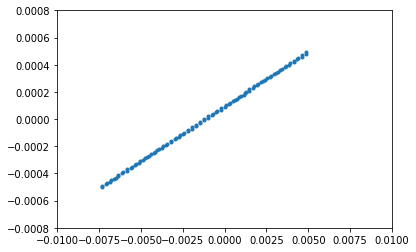

In [15]:
plt.scatter(NIN_Vinc, NIN_Iinc, marker='.')
#from NIN b offset, m=12.46 Ohms, b= -0.0012 V
#for SIN data, T is fixed at 4.2K
#delta = (4.2 K)(kB)(transition temp of lead) = (4.2 K)(kB)(7.175 K) = 0.00259 eV

#plt.plot(NIN_Vinc, NINcurr(SIN_Vinc, [12.46, 0.00259, 4.2]))
plt.ylim(-0.0008, 0.0008)
plt.xlim(-0.01, 0.01)

In [28]:
#main method -- minimizing chi squared
def herbertSIN(v, current, current_err, firstGuess = []):

    #original parameter guesses
    r    = firstGuess[0]
    delt = firstGuess[1]
    t    = firstGuess[2]
    
    #range over which to evaluate 
    #R range is small
    R_range   = np.arange(10, 20, 1)
    del_range = np.arange(0.002, 0.003, 0.0001)
    T_range   = np.arange(3.5, 4.5, 0.1)
    
    #final optimized values of fit parameters
    optim_R   = 0
    optim_del = 0
    optim_T   = 0
    
    #default maximum value
    scoreboard = 1000000000000000000000000
    
    for i in range(len(R_range)):
        for j in range(len(del_range)):
            for k in range(len(T_range)):
                #calculate reduced chi squared
                sum_lsq = 0
                
                for m in range(len(v)):
                    lsq = ((SINcurr(v, [R_range[i], del_range[j], T_range[k]])[m]-current[m])**2)/(current_err[m]**2)
                    sum_lsq += lsq
                    
                chi_sq = lsq / (len(v)-3)
                if(chi_sq < scoreboard):
                    print("surpassed scoreboard")
                    scoreboard = chi_sq
                    optim_R    = R_range[i]
                    optim_del  = del_range[j]
                    optim_T    = T_range[k]
                        
    print("R: " + str(optim_R) + "\ndelta: " + str(optim_del) + "\nT: " + str(optim_T))   
    return optim_R, optim_del, optim_T
        
    

In [32]:
#main method -- minimizing chi squared
def herbertNIN(v, current, current_err, firstGuess = []):

    #original parameter guesses
    r_0   = firstGuess[0]
    r_sig = firstGuess[1]
    b_0   = firstGuess[2]
    b_sig = firstGuess[3]
    
    #range over which to evaluate 
    #R range is small
    R_range = np.arange(r_0 - r_sig, r_0 + r_sig, (2 * r_sig)/10)
    b_range = np.arange(b_0 - b_sig, b_0 + b_sig, (2 * b_sig)/10)
    
    #final optimized values of fit parameters
    optim_R = 0
    optim_b = 0
    
    #default maximum value
    scoreboard = 1000000000000000000000000
    
    for j in range(len(R_range)):
        for k in range(len(b_range)):
            #calculate reduced chi squared
            sum_lsq = 0

            for m in range(len(v)):
                if current_err[m] == 0:
                    current_err[m] = (NINcurr(v, [ R_range[j], b_range[k] ])[m]/10
                    
                lsq = ((NINcurr(v, [ R_range[j], b_range[k] ])[m] - current[m])**2)/(current_err[m]**2)
                sum_lsq += lsq

            print("lsq = " + str(lsq))    
            chi_sq = lsq / (len(v)-2)
            print("chisq = " + str(chi_sq))
            if(chi_sq < scoreboard):
                print("surpassed scoreboard")
                scoreboard = chi_sq
                optim_R    = R_range[j]
                optim_b    = b_range[k]
                        
    print("R: " + str(optim_R) + "\nb: " + str(optim_b))   
    return optim_R, optim_b
        

SyntaxError: invalid syntax (<ipython-input-32-e6f19fe91f14>, line 31)

C:\Users\clair\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars


lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf
chisq = inf
lsq = inf


(-0.01, 0.01)

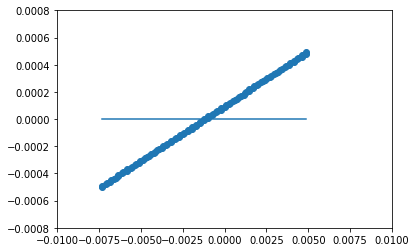

In [33]:
optim_R, optim_b = herbertNIN(NIN_Vinc, NIN_Iinc, NIN_Vinc_err, [.12, .05, 0, .0002])

plt.plot(NIN_Vinc, NINcurr(NIN_Vinc, [optim_R, optim_b]))
plt.scatter(NIN_Vinc, NIN_Iinc)
plt.ylim(-0.0008, 0.0008)
plt.xlim(-0.01, 0.01)

C:\Users\clair\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
surpassed scoreboard
R: 10
delta: 0.0025
T: 4.399999999999999


(-0.01, 0.01)

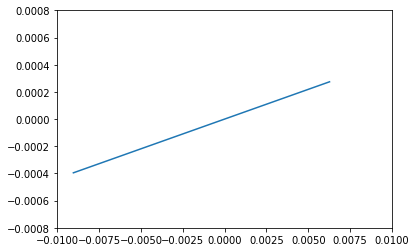

In [29]:
optim_R, optim_del, optim_T = herbert(SIN_Vinc, SIN_Iinc, SIN_Vinc_err, [12.46, 0.00259, 4.2])

plt.plot(SIN_Vinc, SINcurr(SIN_Vinc, [optim_R, optim_del, optim_T]))
plt.ylim(-0.0008, 0.0008)
plt.xlim(-0.01, 0.01)

(-0.01, 0.01)

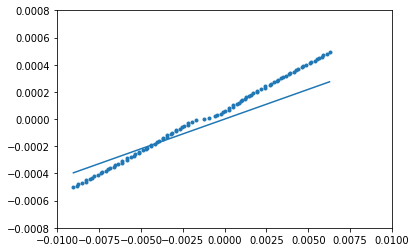

In [9]:
plt.scatter(SIN_Vinc, SIN_Iinc, marker='.')
#from NIN b offset, m=12.46 Ohms, b= -0.0012 V
#for SIN data, T is fixed at 4.2K
#delta = (4.2 K)(kB)(transition temp of lead) = (4.2 K)(kB)(7.175 K) = 0.00259 eV

plt.plot(SIN_Vinc, SINcurr(SIN_Vinc, [10, .0025, 4.3999999]))
plt.ylim(-0.0008, 0.0008)
plt.xlim(-0.01, 0.01)

In [30]:
def red_chisq(o, c, var, m):
    #v = n - m
    v = len(o) - m
    chi = 0
    for i in range(len(o)):
        chi = chi + ( (o[i] - c[i])**2) / (var[i]**2)
        #print(o[i]-c[i])
        #print(str(beta[i])+ ": "+str((o[i]-c[i])**2/var[i]**2))
        
    return chi / v